# Building a Model to Predict When Customers Are Going to End Their Subscriptions For Interconnect

Interconnect is a phone and internet provider who wants a machine learning model that can predict when customers are going to end their subscriptions ahead of time so that Interconnect can ensure their loyalty by offering them promotional offers. What follows is a data exploration and work plan for the best approach to accomplishing this task.

In [1]:
!pip install pyarrow
!pip install shap
!pip install catboost

## Import Necessary Modules

In [2]:
# Typing for type hints
from typing import Optional

# Standard library imports
import re
from functools import reduce
import inspect

# Third-party library imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns
import statsmodels.api as sm

# Scikit-learn imports
from sklearn.base import BaseEstimator
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

## Load Data

In [3]:
cd ..

C:\Users\Caitlin\Documents\Brett_TTT_projects\predicting_cust_churn


In [4]:
df_contract = pd.read_csv('contract.csv')
df_personal = pd.read_csv('personal.csv')
df_internet = pd.read_csv('internet.csv')
df_phone = pd.read_csv('phone.csv')

## Inspect Data and Clean Data

In [5]:
print(df_contract.info())
df_contract

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB
None


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65
...,...,...,...,...,...,...,...,...
7038,6840-RESVB,2018-02-01,No,One year,Yes,Mailed check,84.80,1990.5
7039,2234-XADUH,2014-02-01,No,One year,Yes,Credit card (automatic),103.20,7362.9
7040,4801-JZAZL,2019-03-01,No,Month-to-month,Yes,Electronic check,29.60,346.45
7041,8361-LTMKD,2019-07-01,2019-11-01 00:00:00,Month-to-month,Yes,Mailed check,74.40,306.6


In [6]:
df_contract.isna().sum()

customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
dtype: int64

The only column where a duplicate would indicate a surefire mistake would be 'customer_ID'. Let's give it a look. 

In [7]:
df_contract['customerID'].duplicated().sum()

np.int64(0)

Date is another one we might not expect a duplicate. Let's checkt the unique value to see if we should expect duplicates. 

In [8]:
print(df_contract['EndDate'].unique())

['No' '2019-12-01 00:00:00' '2019-11-01 00:00:00' '2019-10-01 00:00:00'
 '2020-01-01 00:00:00']


Clearly, there is a pattern to when people end their subscriptions. All duplicates in this column are to be expected.

In [9]:
print(df_personal.info())
df_personal

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB
None


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No
...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes
7039,2234-XADUH,Female,0,Yes,Yes
7040,4801-JZAZL,Female,0,Yes,Yes
7041,8361-LTMKD,Male,1,Yes,No


In [10]:
df_personal.isna().sum()

customerID       0
gender           0
SeniorCitizen    0
Partner          0
Dependents       0
dtype: int64

In [11]:
df_personal.duplicated().sum()

np.int64(0)

In [12]:
df_personal['customerID'].duplicated().sum()

np.int64(0)

In [13]:
print(df_internet.info())
df_internet

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB
None


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No
...,...,...,...,...,...,...,...,...
5512,6840-RESVB,DSL,Yes,No,Yes,Yes,Yes,Yes
5513,2234-XADUH,Fiber optic,No,Yes,Yes,No,Yes,Yes
5514,4801-JZAZL,DSL,Yes,No,No,No,No,No
5515,8361-LTMKD,Fiber optic,No,No,No,No,No,No


In [14]:
df_internet.isna().sum()

customerID          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
dtype: int64

In [15]:
df_internet.duplicated().sum()

np.int64(0)

In [16]:
df_internet['customerID'].duplicated().sum()

np.int64(0)

In [17]:
print(df_phone.info())
df_phone

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB
None


,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes
...,...,...
6356,2569-WGERO,No
6357,6840-RESVB,Yes
6358,2234-XADUH,Yes
6359,8361-LTMKD,Yes


In [18]:
df_phone.isna().sum()

customerID       0
MultipleLines    0
dtype: int64

In [19]:
df_phone['customerID'].duplicated().sum()

np.int64(0)

In [20]:
# Create list of non-standard null values
non_standard_null_values = ['', 'na', 'null', 'missing']

def non_standard_null_search(df):
    for col in df.columns:
        # Create conditional "if the datatype for a given column is object datatype." 
        if df[col].dtype == 'object': 
            # Assign each column the value it previusly had except with all lower case and all trailing 
            # and leadings spaces stripped. 
            df[col] = df[col].str.strip().str.lower()
            # For each column display the non-standard null values it contains. 
            print(f"{col}: {df[col].isin(non_standard_null_values).sum()}")

In [21]:
non_standard_null_search(df_contract)

customerID: 0
BeginDate: 0
EndDate: 0
Type: 0
PaperlessBilling: 0
PaymentMethod: 0
TotalCharges: 11


In [22]:
df_contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-vhveg,2020-01-01,no,month-to-month,yes,electronic check,29.85,29.85
1,5575-gnvde,2017-04-01,no,one year,no,mailed check,56.95,1889.5
2,3668-qpybk,2019-10-01,2019-12-01 00:00:00,month-to-month,yes,mailed check,53.85,108.15
3,7795-cfocw,2016-05-01,no,one year,no,bank transfer (automatic),42.30,1840.75
4,9237-hqitu,2019-09-01,2019-11-01 00:00:00,month-to-month,yes,electronic check,70.70,151.65


In [23]:
df_contract['TotalCharges'].unique()

array(['29.85', '1889.5', '108.15', ..., '346.45', '306.6', '6844.5'],
      shape=(6531,), dtype=object)

In [24]:
mask = df_contract['TotalCharges'].astype(str).str.contains('([a-zA-Z]+|^$)', na=False)
print(df_contract.loc[mask, 'TotalCharges'])

488     
753     
936     
1082    
1340    
3331    
3826    
4380    
5218    
6670    
6754    
Name: TotalCharges, dtype: object


C:\Users\Caitlin\AppData\Local\Temp\ipykernel_25500\1235251770.py:1: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mask = df_contract['TotalCharges'].astype(str).str.contains('([a-zA-Z]+|^$)', na=False)


Okay, we are dealing with some empty strings in the total_charges column. Since we are going to rely on gradient boosting algorithms for this project we can use to_numeric and coerce the empty strings to NaN values because gradient boosting algorithms can handle NaN values gracefully.

In [25]:
# Convert to numeric and coerce errors to NaN
df_contract['TotalCharges'] = pd.to_numeric(df_contract['TotalCharges'], errors='coerce')

In [26]:
non_standard_null_search(df_personal)

customerID: 0
gender: 0
Partner: 0
Dependents: 0


In [27]:
non_standard_null_search(df_internet)

customerID: 0
InternetService: 0
OnlineSecurity: 0
OnlineBackup: 0
DeviceProtection: 0
TechSupport: 0
StreamingTV: 0
StreamingMovies: 0


In [28]:
non_standard_null_search(df_phone)

customerID: 0
MultipleLines: 0


In [29]:
df_phone.head()

,customerID,MultipleLines
0,5575-gnvde,no
1,3668-qpybk,no
2,9237-hqitu,no
3,9305-cdskc,yes
4,1452-kiovk,yes


In [30]:
def clean_column_names(name):
    name = name.strip()
    # Insert underscore before a capital letter preceded by a lowercase letter or number 
    return re.sub(r'(?<=[a-z0-9])([A-Z])', r'_\1', name).lower()

In [31]:
df_contract.columns = [clean_column_names(col) for col in df_contract.columns]
df_contract.columns

Index(['customer_id', 'begin_date', 'end_date', 'type', 'paperless_billing',
       'payment_method', 'monthly_charges', 'total_charges'],
      dtype='object')

In [32]:
df_personal.columns = [clean_column_names(col) for col in df_personal.columns]
df_personal.columns

Index(['customer_id', 'gender', 'senior_citizen', 'partner', 'dependents'], dtype='object')

In [33]:
df_internet.columns = [clean_column_names(col) for col in df_internet.columns]
df_internet.columns

Index(['customer_id', 'internet_service', 'online_security', 'online_backup',
       'device_protection', 'tech_support', 'streaming_tv',
       'streaming_movies'],
      dtype='object')

In [34]:
df_phone.columns = [clean_column_names(col) for col in df_phone.columns]
df_phone.columns

Index(['customer_id', 'multiple_lines'], dtype='object')

In [35]:
df_contract['begin_date'] = pd.to_datetime(df_contract['begin_date'], format="%Y-%m-%d", errors='coerce')
df_contract['end_date'] = pd.to_datetime(df_contract['end_date'].replace("No", pd.NaT), format="%Y-%m-%d %H:%M:%S", errors='coerce')

In [36]:
df_contract['end_date'].unique()

<DatetimeArray>
[                'NaT', '2019-12-01 00:00:00', '2019-11-01 00:00:00',
 '2019-10-01 00:00:00', '2020-01-01 00:00:00']
Length: 5, dtype: datetime64[ns]

## Work Plan

We have four DataFrames: df_contract, df_personal, df_internet, and df_phone. Ultimately, we want to be able to feed our model as much information as possible. Hower, there is a problem, because not every customer who has phone service also has internet service and vice versa. This means that if we use all of the features we will have large number of NaN values in phone categories for customers who only have internet and vice versa. For this reason (and others) gradient boosting algorithms are ideal for this task. They can handle the NaN values natively, which means that we can simply merge these DataFrames without worrying about the NaN values that are created. 

There are a lot of creative feature engineering approaches we can take as well. One thing we can do is set up a p_i_or_b feature (phone, internet, or both). There are also a lot of options available to us utilizing the date features from df_contract: begin_date and end_date. Of course, we will have end_date will ultimately be converted into our binary target_feature 'churn'. Therefore, we cannot directly utilize information fron end_date because it would be giving away the answers to the model. However, we can use it to create a 'customer_duration' feature, which could be real asset. We can also extract a number of features from begin date. We can get the year, the month, the day of the year, the day of the month, and the day of the weak. Moreover, we can encode these both as categorical variables, and as intervals on the unit circle (via sine and cosine) which would of course be numeric variables. To the degree that the categorical nature of the variable is what is predictive the model can rely on the extracted date features which are encoded as categorical variables. To the extent that cyclical trends are predictive (i.e. later in the week as opposed to Friday specifically) the model can rely on the numeric versions of the extracted date features. 

Unfortunately, the model cannot utilize both the extracted date features and a customer_duration feature, as knowledge of the start date in conjunction with the duration subscription would lead to data leakage. For example, if the customer signed up in 2014, but the duration is under 300 days, the model will automatically know the customer churned. There may be an exception for dayofweek features, but this is tricky too. Since all contracts start and end on the first of the month. This would mean that if two customers started on different days but had the same duration, one of them would have had to have churned. So, again, we would be dealing with a data leakage problem. Another concern regarding a 'customer_duration' feature is that, in real life, if the model requires a duration metric up to the present date to make a prediction, it is useless, because the promotional offer likely will not make it onto the customer's radard before they decide to churn. Instead we want to be able to predict churn at least a week or two in advance. 

We can, potentially kill two birds with one stone by subtracting random values from customer duration. We would want a range of values that are roughly equal to the time by which we want to pre-empt a predicted churn with a promotional offer. We would also want a range large enough to erase any delimiting capabilities that could be available to dayofweek_sin and dayofweek_cos. Since the farthest two days in a week can be from each other (when cyclicality is taken into account) is 3 on either the front end or the back end, an integer range of 3 would be a good place to start. With all these considerations in mind I will use random float values between 13 and 15 for this purpose if we decide it is adventageous to implement it. By subtracting these days we have also created a model that can predict the churn ahead of time so it will be ready for real world implementation. 

Once we have our different feature options we will try the different combinations of features that do not lead to data leakage with LightGBM, CatBoost, and XGBoost classififiers. The models themselves will have their hyperparameters tuned via GridSearchCV in a GPU envrionment on google colab (utilizing A100 GPUs). 

So with all of that in mind, here are the steps that have to be taken from here on out to complete the project:

1. Merge DataFrames
2. Eingeer all aforementinoed features
3. Perform EDA - specifically, make sure training distributions match test distributions
4. Make necessary adjustements to data for the given model (LGBM and XGB handle categorical variables differently than CatBoost)
5. Check which non-data leakage inducing combination of features the model performs best with via GridSearch cross validation
6. Adjust features based on SHAP output
8. Tune hyperparameters for models with best fetures
9. Retrain model on full training set and test model
10. Generate script files for hyperparameter tuning of each model and for best model and hyperparameters test run

Steps 1-3 will be completed in what remains of this notebook. The rest will be submitted at a later time. 

Ultimately, we will merge all of the DataFrames in one line of code. However, merging df_personal and df_contract will help us engineer our 'p_i_or_b' feature. So, that is where we will start. 

In [37]:
# Merge df_personal and df_contract
personal_and_contract = pd.merge(df_contract, df_personal, on='customer_id', how='inner')

In [38]:
personal_and_contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           1869 non-null   datetime64[ns]
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7032 non-null   float64       
 8   gender             7043 non-null   object        
 9   senior_citizen     7043 non-null   int64         
 10  partner            7043 non-null   object        
 11  dependents         7043 non-null   object        
dtypes: datetime64[ns](2), float64(2), int64(1), object(7)
memory usage: 660.4+ KB


In [39]:
# Merge all loaded DataFrames (still for the sake of feature engineering)
dfs = [df_contract, df_personal, df_internet, df_phone]
merged_df = reduce(lambda left, right: pd.merge(left, right, on='customer_id', how='inner'), dfs)

In [40]:
print(merged_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4835 entries, 0 to 4834
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        4835 non-null   object        
 1   begin_date         4835 non-null   datetime64[ns]
 2   end_date           1586 non-null   datetime64[ns]
 3   type               4835 non-null   object        
 4   paperless_billing  4835 non-null   object        
 5   payment_method     4835 non-null   object        
 6   monthly_charges    4835 non-null   float64       
 7   total_charges      4832 non-null   float64       
 8   gender             4835 non-null   object        
 9   senior_citizen     4835 non-null   int64         
 10  partner            4835 non-null   object        
 11  dependents         4835 non-null   object        
 12  internet_service   4835 non-null   object        
 13  online_security    4835 non-null   object        
 14  online_b

We performed an inner merge for df_personal and df_contract, and we also performed an inner merge between those two DataFrames and the remaning DataFrames we have loaded as well. The reason for this is that we wanted to create boolean masks using the presence of 'customer_id' in these respective DataFrames. We will have a mask for when customer_id appears in both phone and internet, one for when it appears in df_phone only, and another for when it appears in df_internet only. 

In [41]:
personal_and_contract['p_i_or_b'] = None # initialize column

# Create boolean masks that return True when conditions our met
mask_both = personal_and_contract['customer_id'].isin(merged_df['customer_id'])
mask_internet = personal_and_contract['customer_id'].isin(df_internet['customer_id'])
mask_phone = personal_and_contract['customer_id'].isin(df_phone['customer_id'])

# Use boolean masks with .loc to engineer 'p-i_or_b' feature
personal_and_contract.loc[mask_both, 'p_i_or_b'] = 'both'
personal_and_contract.loc[~mask_both & mask_internet, 'p_i_or_b'] = 'internet'
personal_and_contract.loc[~mask_both & ~mask_internet & mask_phone, 'p_i_or_b'] = 'phone'

In [42]:
personal_and_contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           1869 non-null   datetime64[ns]
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7032 non-null   float64       
 8   gender             7043 non-null   object        
 9   senior_citizen     7043 non-null   int64         
 10  partner            7043 non-null   object        
 11  dependents         7043 non-null   object        
 12  p_i_or_b           7043 non-null   object        
dtypes: datetime64[ns](2), float64(2), int64(1), object(8)
memory us

In [43]:
dfs = [personal_and_contract, df_internet, df_phone]

# We are going to perform an outer merge because we don't want to lose data and the resulting NaN values will not be a problem 
# for the gradient boosting models we will train.
all_data = reduce(lambda left, right: pd.merge(left, right, on='customer_id', how='outer'), dfs)

In [44]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           1869 non-null   datetime64[ns]
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7032 non-null   float64       
 8   gender             7043 non-null   object        
 9   senior_citizen     7043 non-null   int64         
 10  partner            7043 non-null   object        
 11  dependents         7043 non-null   object        
 12  p_i_or_b           7043 non-null   object        
 13  internet_service   5517 non-null   object        
 14  online_s

In [45]:
# Create a target column from 'end_date' column 
all_data['churn'] = np.where(all_data['end_date'].isna(), 0, 1)
all_data.head()

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,...,p_i_or_b,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,churn
0,0002-orfbo,2019-05-01,NaT,one year,yes,mailed check,65.6,593.30,female,0,...,both,dsl,no,yes,no,yes,yes,no,no,0
1,0003-mknfe,2019-05-01,NaT,month-to-month,no,mailed check,59.9,542.40,male,0,...,both,dsl,no,no,no,no,no,yes,yes,0
2,0004-tlhlj,2019-09-01,2020-01-01,month-to-month,yes,electronic check,73.9,280.85,male,0,...,both,fiber optic,no,no,yes,no,no,no,no,1
3,0011-igkff,2018-12-01,2020-01-01,month-to-month,yes,electronic check,98.0,1237.85,male,1,...,both,fiber optic,no,yes,yes,no,yes,yes,no,1
4,0013-exchz,2019-09-01,2019-12-01,month-to-month,yes,mailed check,83.9,267.40,female,1,...,both,fiber optic,no,no,no,yes,yes,no,no,1


We need a date to use to create our 'customer_duration' feature. We will use the latest date available in any of our data sets.

In [46]:
# Find the most recent date across both date columns
latest_date = pd.concat([all_data['begin_date'], all_data['end_date']]).max()
print(latest_date)

2020-02-01 00:00:00


As noted in the data description we were provided, the most recent date in the data set is February 1, 2020. For the sake of engineering a 'customer_duration' feature, we will assume that we are creating this model on February 1, 2020. Therefore, any accounts that are still active will only be considered to be active as of February 1, 2020 as opposed to today's actual date. However, we will be subtracting a random float value between 13 and 15 from the initial 'customer_duration' feature. This means that the models will be trained on data we would have available to us at the time we want to make our predictions in the real world. It will also prevent any data leakage that might result from regular patterns that appear between 'customer_duration' and 'churn'. If certain durations are always churned and others are never churned, we are certainly comitting the sin of data leakage. By subtracting random values between 13 and 15 we can introduce a little randomness into our 'customer_duration' feature. This is especially important if we want to maintain any dayofweek features in our training data. Moreover, becaus we are keeping the range to 3 days we will not negatively impact any signal that exists between 'customer_duration' and 'churn'.

In [47]:
# Calculate customer duration
all_data['customer_duration'] = np.where(
    all_data['end_date'].isna(), (latest_date - all_data['begin_date']).dt.days, (
        all_data['end_date'] - all_data['begin_date']).dt.days)

In [48]:
all_data['begin_date'].max()

Timestamp('2020-02-01 00:00:00')

In [49]:
all_data['customer_duration'].nunique()

156

Now let's subtract random float values between 12 and 15.

In [50]:
# Generate a different random value between 13 and 15 for each row
random_values = np.random.uniform(12, 15, size=len(all_data))

#Check to make sure our random values are what we expect them to be
print(random_values.max())
print(random_values.min())

# Subtract random float values from 'customer_duration
all_data['customer_duration'] = all_data['customer_duration'] - random_values

14.999613683774655
12.000115838143424


### Engineering date features

Now let's engineer our other date features. 

In [51]:
all_data['start_year_int'] = all_data['begin_date'].dt.year.astype(int)

all_data['start_year_cat'] = all_data['begin_date'].dt.year.astype(str)

all_data['start_month_int'] = all_data['begin_date'].dt.month.astype(int)

all_data['start_month_cat'] = all_data['begin_date'].dt.day.astype(str)

all_data['start_dayofmonth_int'] = all_data['begin_date'].dt.day.astype(int)

all_data['start_dayofmonth_cat'] = all_data['begin_date'].dt.day.astype(str)

all_data['start_dayofweek_int'] = all_data['begin_date'].dt.dayofweek.astype(int) + 1

all_data['start_dayofweek_cat'] = all_data['begin_date'].dt.dayofweek.astype(str)

all_data['start_dayofyear_int'] = all_data['begin_date'].dt.dayofyear.astype(int)

In [52]:
all_data.head()

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,...,customer_duration,start_year_int,start_year_cat,start_month_int,start_month_cat,start_dayofmonth_int,start_dayofmonth_cat,start_dayofweek_int,start_dayofweek_cat,start_dayofyear_int
0,0002-orfbo,2019-05-01,NaT,one year,yes,mailed check,65.6,593.30,female,0,...,262.207984,2019,2019,5,1,1,1,3,2,121
1,0003-mknfe,2019-05-01,NaT,month-to-month,no,mailed check,59.9,542.40,male,0,...,262.924382,2019,2019,5,1,1,1,3,2,121
2,0004-tlhlj,2019-09-01,2020-01-01,month-to-month,yes,electronic check,73.9,280.85,male,0,...,107.612351,2019,2019,9,1,1,1,7,6,244
3,0011-igkff,2018-12-01,2020-01-01,month-to-month,yes,electronic check,98.0,1237.85,male,1,...,381.598726,2018,2018,12,1,1,1,6,5,335
4,0013-exchz,2019-09-01,2019-12-01,month-to-month,yes,mailed check,83.9,267.40,female,1,...,78.335685,2019,2019,9,1,1,1,7,6,244


In [53]:

# Create function that adds sin and cos columns to capture cyclical patterns for a given column.
def add_cyclical_features(df: pd.DataFrame, old_col_name: str, new_col_name:str, max_val: float) -> pd.DataFrame:
    df[new_col_name + '_sin'] = np.sin(2 * np.pi * df[old_col_name] / max_val)
    df[new_col_name + '_cos'] = np.cos(2 * np.pi * df[old_col_name] / max_val)
    return df


In [54]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 32 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   customer_id           7043 non-null   object        
 1   begin_date            7043 non-null   datetime64[ns]
 2   end_date              1869 non-null   datetime64[ns]
 3   type                  7043 non-null   object        
 4   paperless_billing     7043 non-null   object        
 5   payment_method        7043 non-null   object        
 6   monthly_charges       7043 non-null   float64       
 7   total_charges         7032 non-null   float64       
 8   gender                7043 non-null   object        
 9   senior_citizen        7043 non-null   int64         
 10  partner               7043 non-null   object        
 11  dependents            7043 non-null   object        
 12  p_i_or_b              7043 non-null   object        
 13  internet_service  

### cyclical versions of begin date features

In [55]:

all_data = add_cyclical_features(all_data, 'start_dayofmonth_int', 'start_dayofmonth', 30.44)

all_data = add_cyclical_features(all_data, 'start_month_int', 'start_month', 12.00)

all_data = add_cyclical_features(all_data, 'start_dayofweek_int', 'start_dayofweek', 7.00)

all_data = add_cyclical_features(all_data, 'start_dayofyear_int', 'start_dayofyear', 365.00)


In [56]:
print(all_data.info())
all_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 40 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   customer_id           7043 non-null   object        
 1   begin_date            7043 non-null   datetime64[ns]
 2   end_date              1869 non-null   datetime64[ns]
 3   type                  7043 non-null   object        
 4   paperless_billing     7043 non-null   object        
 5   payment_method        7043 non-null   object        
 6   monthly_charges       7043 non-null   float64       
 7   total_charges         7032 non-null   float64       
 8   gender                7043 non-null   object        
 9   senior_citizen        7043 non-null   int64         
 10  partner               7043 non-null   object        
 11  dependents            7043 non-null   object        
 12  p_i_or_b              7043 non-null   object        
 13  internet_service  

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,...,start_dayofweek_cat,start_dayofyear_int,start_dayofmonth_sin,start_dayofmonth_cos,start_month_sin,start_month_cos,start_dayofweek_sin,start_dayofweek_cos,start_dayofyear_sin,start_dayofyear_cos
0,0002-orfbo,2019-05-01,NaT,one year,yes,mailed check,65.6,593.30,female,0,...,2,121,0.20495,0.978773,5.000000e-01,-8.660254e-01,4.338837e-01,-0.900969,0.871706,-0.490029
1,0003-mknfe,2019-05-01,NaT,month-to-month,no,mailed check,59.9,542.40,male,0,...,2,121,0.20495,0.978773,5.000000e-01,-8.660254e-01,4.338837e-01,-0.900969,0.871706,-0.490029
2,0004-tlhlj,2019-09-01,2020-01-01,month-to-month,yes,electronic check,73.9,280.85,male,0,...,6,244,0.20495,0.978773,-1.000000e+00,-1.836970e-16,-2.449294e-16,1.000000,-0.871706,-0.490029
3,0011-igkff,2018-12-01,2020-01-01,month-to-month,yes,electronic check,98.0,1237.85,male,1,...,5,335,0.20495,0.978773,-2.449294e-16,1.000000e+00,-7.818315e-01,0.623490,-0.493776,0.869589
4,0013-exchz,2019-09-01,2019-12-01,month-to-month,yes,mailed check,83.9,267.40,female,1,...,6,244,0.20495,0.978773,-1.000000e+00,-1.836970e-16,-2.449294e-16,1.000000,-0.871706,-0.490029


In [57]:
features = all_data.drop(columns=['customer_id', 
                                  'churn', 
                                  'begin_date', 
                                  'end_date',
                                  'start_month_int',
                                  'start_dayofmonth_int',
                                  'start_dayofweek_int',
                                  'start_dayofyear_int'])
target = all_data['churn']

features_train, features_test, target_train, target_test = train_test_split(features, target, stratify=target, test_size=0.2, random_state=12345)

In [58]:
for col_name in features_train.columns:
    print(f"Train {col_name}: {features_train[col_name].describe()}\n Test {col_name}: {features_test[col_name].describe()}\n\n")

Train type: count               5634
unique                 3
top       month-to-month
freq                3085
Name: type, dtype: object
 Test type: count               1409
unique                 3
top       month-to-month
freq                 790
Name: type, dtype: object


Train paperless_billing: count     5634
unique       2
top        yes
freq      3335
Name: paperless_billing, dtype: object
 Test paperless_billing: count     1409
unique       2
top        yes
freq       836
Name: paperless_billing, dtype: object


Train payment_method: count                 5634
unique                   4
top       electronic check
freq                  1891
Name: payment_method, dtype: object
 Test payment_method: count                 1409
unique                   4
top       electronic check
freq                   474
Name: payment_method, dtype: object


Train monthly_charges: count    5634.000000
mean       64.644054
std        30.165390
min        18.250000
25%        35.212500
50%       

The only categorical variable which did not have the same top value between training and testing sets was 'start_dayofweek'. Let's get a look at the value_counts for this variable from our training and testing sets.

In [59]:
print(f"{features_train['start_dayofweek_cat'].value_counts()}\n\n {features_test['start_dayofweek_cat'].value_counts()}")

start_dayofweek_cat
5    998
6    871
4    864
1    770
2    759
3    704
0    668
Name: count, dtype: int64

 start_dayofweek_cat
6    248
5    227
2    204
4    204
0    179
1    178
3    169
Name: count, dtype: int64


We can see that there are some differences in the distribution between start_dayofweek_cat in the training and testing distributions. This is not necessarily a problem as each value is receiving adequate representation in the trianing set (which is most important) as well as in the test set. However, this result does suggewst something important about the start_dayofweek_cat feature which is that start_dayofweek may not be that predictive of churn. Since we set stratify=target in our train_test_split method the different values of our binary target variable will be evenly distributed between the test and target sets. Therefore, if a feature were highly predictive of our target variable, we would expect that an equal distribution of target variable values between training and test sets would lead to an equal distribution of that feature's values between training and test set. This relationship is merely a tendency, however, because there may be particular combinations of the other variables which may overpower the relevance of this single start_dayofweek_cat variable, such that equal target variable value distribution does not entail equal start_dayofweek_cat feature distribution. It also may be the case that the test set is just no large enough to reveal this relationship even if it exists. We will find out for sure when we run the feature_importance() metod on our gradient boosting models. 

In totality, we can see from the above output that the distributions for each feature are pretty similar between training and test set. On occasion, there is a mild category error when binary categorical variables are encoded as int dtypes. However, the frequency of the given answer can still be discerned based on the mean because in these instances mean can just be interpreted as the percentage of responses that had a positive answer. Therefore, insofar as those means between the training set feature and the test set feature are equal or similar, we know we have similar enough distributions for that feature between our training and test set.  

The distributions of the feature variables were between training and test sets were quite similar. As noted above, when we set stratify=target and our feature variable values are not evenly distributed between training and test sets, this suggests that that feature may not be very predictive of the target variable value. However, the reverse is also true. When the feature variable values are evenly distributed between training and test sets when we have stratified the target variable, this suggests that the feature variable is predictive of the target variable value. Moreover, while this relationship is only suggestive, the more features we have whose values are equally distributed between training and test sets, the more likely it is that our features are picking up on genuine signal between the features and the target. In other words, even though anyone of these given feature variables may only be weakly predictive of the target variable on its own, widespread equal distribution between training and test sets of feature variable values is strong evidence that there is a relationship between the features and the target. In other words, preliminarily, we seem to be in pretty good shape. 

We might also note that describe() offers more detail for numeric variables, revealing that while the central tendancies of the datetime variables we translated to radians spanned on the unit circle for sin and cosine measurements showed some discrepancy, each discrepancy between the central tendancies of those variables between the training and test sets did not even amount to half a standard deviation. Moreover, we can also see that from the identical medians that any discrpancies between the means likely resulted from outliers. All of this is true for the start_datyofweek variable as well. Therefore, while start_dayofweek appeared to have notable difference when encoded categorically (suggesting a lacking relatinoship to the target variable value), it is likely that the relationship is there, but has an ordinal quality to it. That is, the relationship may not between canceling subscription and Friday per say, but there may be relationship between canceling a subscription and a time later in the week. This kind of tendency would be better captured by the ordinal structure of encoding these datetime variables as radians on the unit circle when measured in terms of both sin and cosine. That is why I encoded both ategorical and cylcial versions of these variables. 

Let's get a closer look at the start_dayofweek sine and cosine feature and the start_dayofweek_cat distributions for both the training set and the test set since this was the variable that showed the most discrepancy. Let's also get a look at the contract type, paperless billing, payment method, monthly charges, and total charges variables, as, a-priori, I suspect these will be pivotal.  

In [60]:
# Instruct matplotlib to use seaborn presentation style
plt.style.use('seaborn-v0_8')
sns.set_theme(style='whitegrid')

In [61]:
# Create list of names and DataFrames for easy plotting with for loops
names = ['Train', 'Test']
df_list = [features_train, features_test]
hist_cols = ['monthly_charges', 'total_charges', 'customer_duration']
x_ticks_range = [range(0, 150, 25), range(0, 10000, 2000), range(-13, 2200, 600)]
plot_index = 1

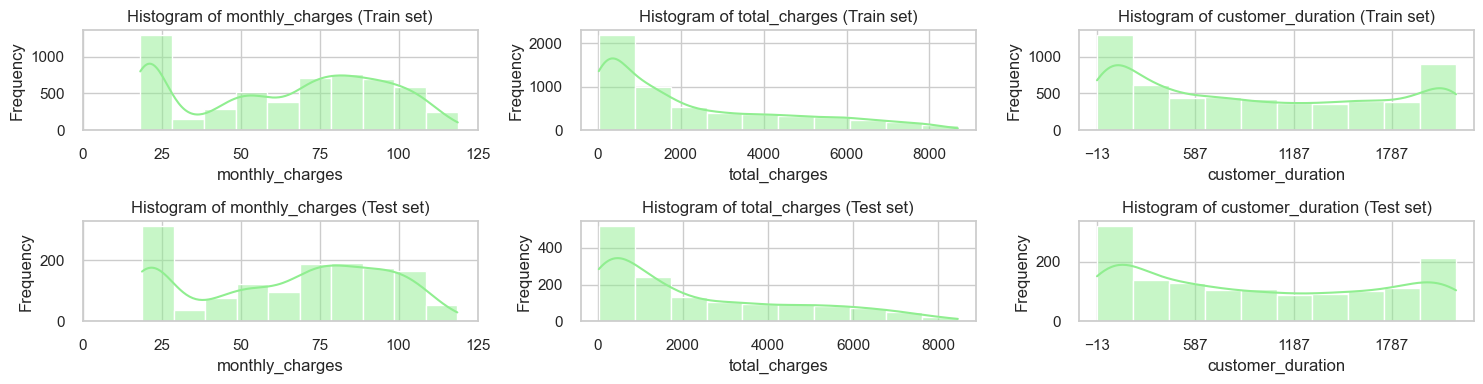

In [62]:
plt.figure(figsize=(15, 4))
for df, name in zip(df_list, names):
    for col, tick in zip(hist_cols, x_ticks_range):
        plt.subplot(2, 3, plot_index)
        sns.histplot(data=df, x=df[col], bins=10, kde=True, color='lightgreen')
        plt.xticks(ticks=tick)
        plt.title(f'Histogram of {col} ({name} set)')
        plt.xlabel(f"{col}")
        plt.ylabel('Frequency')
        plot_index += 1
plt.tight_layout()
plt.show()

Evidently, the distributions for these features between the training and test sets are quite similar. The only feature that shows any deviation at all is start_dayofweek_cos where 0.5 shows the greatest frequency in the training set and is tied for second greatest frequency in the test set. Otherwise, the distributions for this feature are quite similar, and the distributions for the other features are nearly identical. 

Next, let's get a look at the categorical variables we said we would plot. 

In [63]:
bar_plot_cols = ['type', 'payment_method', 'p_i_or_b']
plot_index = 1

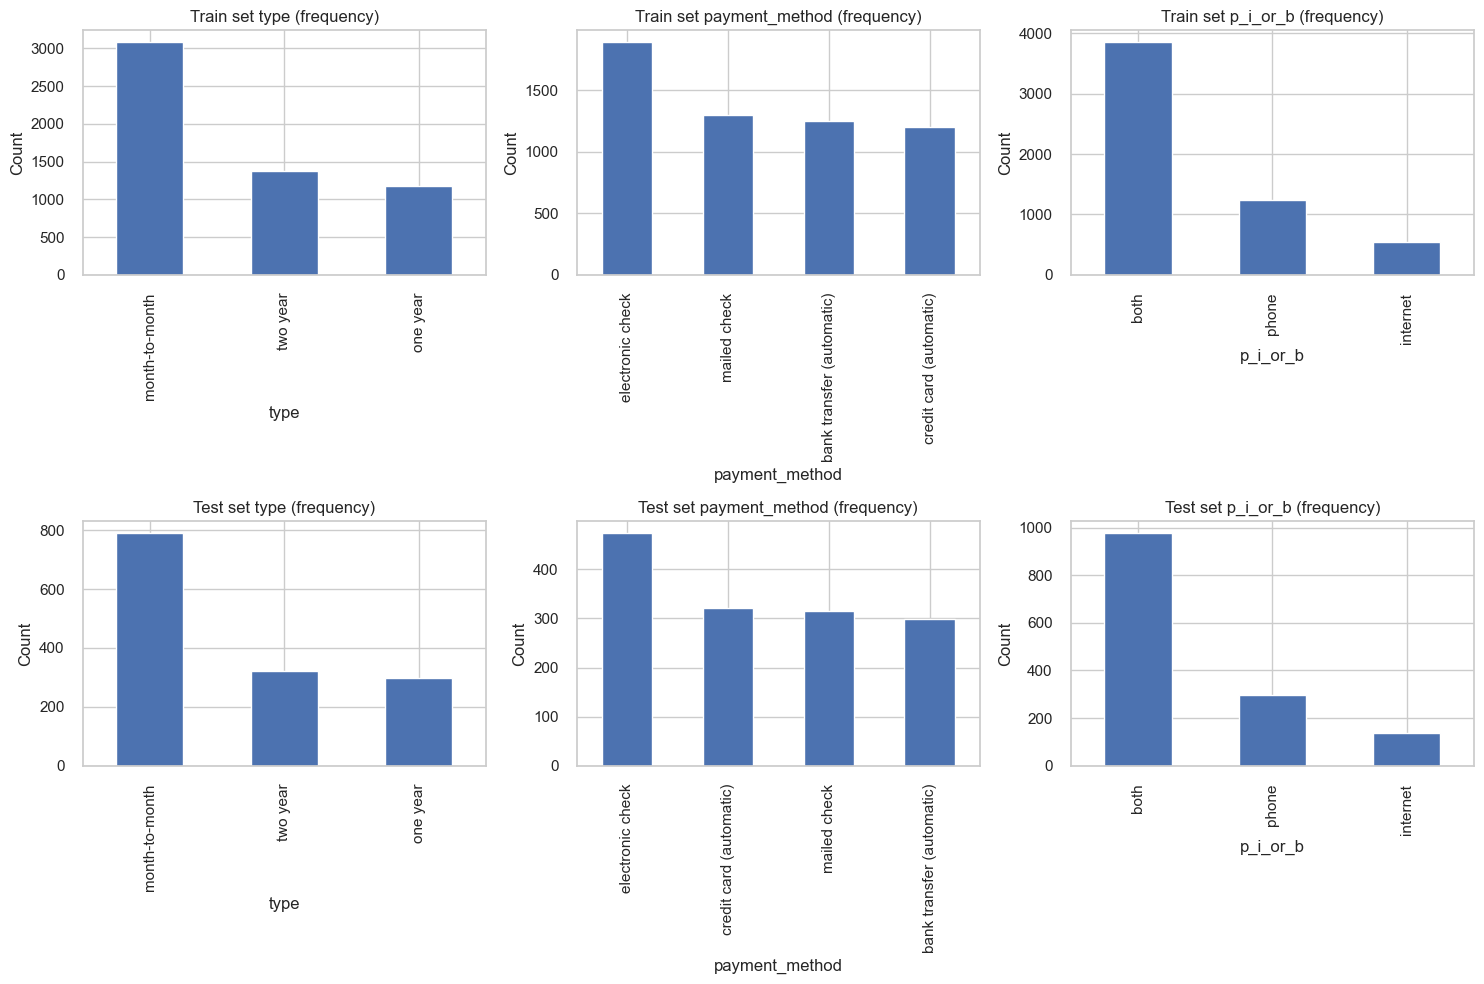

In [64]:
# Set up subplots
plt.figure(figsize=(15, 10))
for df, name in zip(df_list, names):
    for col in bar_plot_cols:
        plt.subplot(2, len(bar_plot_cols), plot_index)
        df[col].value_counts().plot(kind='bar')
        plt.title(f'{name} set {col} (frequency)')
        plt.xlabel(col)
        plt.ylabel('Count')
        plt.xticks(rotation=90)
        plot_index += 1

plt.tight_layout()
plt.show()

Again, these distributions are quite similar. The distribution of the 'type' feature between the two data sets is virtually identical. However, there are some slight differences for the latter two features. For 'payment_method', credit card (automatic), mailed check, and bak transfer (automatic) are all nearly identical. However, in the training set mailed check is second most common, bank transfer (automatic) is third most common, and credit card (automatic) is least common. Meanwhile, for the test set, credit card (automatic) is second most common, mailed check is third most common, and bank transfer (automatic) is least common. For both sets, electronic check was most popular.

As we had noted above, there was considerable variability in the order of the modes of the distribution even though the shape of the distribution is nearly identical. I will simply list the mode orderings of the values in those distributions below:

Training set:

Saturday (5)  
Sunday (6)  
Friday (4)  
Tuesday (1)  
Wednesday (2)  
Thursday (3)  
Monday (0)  
Test set:

Sunday (6)  
Saturday (5)  
Wednesday (2)  
Friday (4)  
Monday (0)  
Tueday (1)  
Thursday (3).  

While there is some discrepancy here, it is fair to say that for both distributions, days considered part of the weekend (including Friday) were the most common start days and days towards the beginning of the week tended to be the least common start days. This likely reflects the fact that people have more time to sign up for services during the weekend when they are not working.

Let's also get a look at the distribution of our target variable values. 

In [65]:
target_train.value_counts()

churn
0    4139
1    1495
Name: count, dtype: int64

In [66]:
target_test.value_counts()

churn
0    1035
1     374
Name: count, dtype: int64

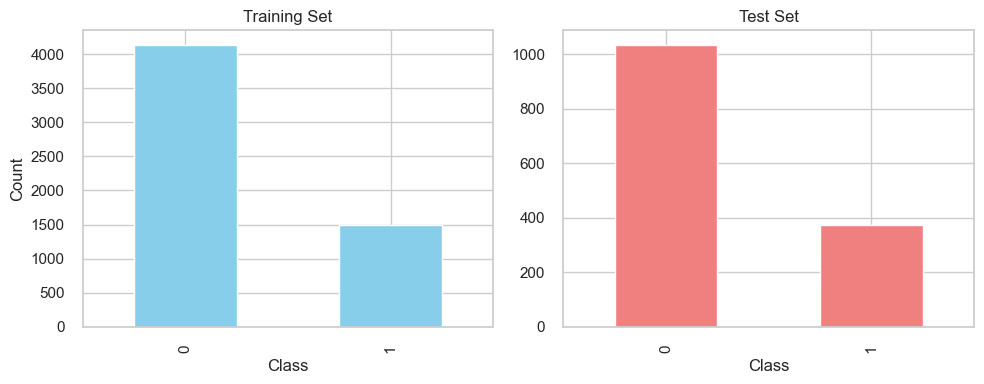

In [67]:
# Create figure and subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Plot for target_train
target_train.value_counts().sort_index().plot(kind='bar', ax=axes[0], color='skyblue')
axes[0].set_title('Training Set')
axes[0].set_xlabel('Class')
axes[0].set_ylabel('Count')
axes[0].set_xticks([0, 1])
axes[0].set_xticklabels(['0', '1'])

# Plot for target_test
target_test.value_counts().sort_index().plot(kind='bar', ax=axes[1], color='lightcoral')
axes[1].set_title('Test Set')
axes[1].set_xlabel('Class')
axes[1].set_xticks([0, 1])
axes[1].set_xticklabels(['0', '1'])

plt.tight_layout()
plt.show()

As you can see, the distribution shape for the target variable is nearly identical between the trianing and test set. 

In conclusion, we still have to perform the following steps:

4. Make necessary adjustements to data for the given model (LGBM and XGB handle categorical variables differently than CatBoost)
5. Check which non-data leakage inducing combination of features the model performs best with via GridSearch cross validation
6. Adjust features based on SHAP output
7. Tune hyperparameters for models with best features
8. Retrain model on full training set and test model
9. Generate script files for hyperparameter tuning of each model and for best model and hyperparameters test run

Thus far we have demonstrated that all of our features share similar distributions in the training and test sets, as does our target variable. After I have discerned which non data leaking combination of features the models perform best with, I will download those features I will generate a script file for the selection and downloading of those features via parquet() to maintain dtype integrity between platforms. Then I will do the same for the hyperparameter tuning for each model and the training for the final model.

The questions which we have yet to answer are as follows:

1. Can we utilize the 'customer_duration' feature without introducing data leakage? 
2. Can we utilize 'customer_duration' with start_dayofweek_sin, start_dayofweek_cos, and start_dayofweek_cat without introducing data leakage?
3. What non data leakage inducing combinatino of features will lead to the best model performance? 

In [68]:
categorical_cols = ['type',
                    'total_charges',
                    'paperless_billing',
                    'payment_method',
                    'gender', 
                    'partner',
                    'dependents',
                    'p_i_or_b',
                    'internet_service',
                    'online_security',
                    'online_backup',
                    'device_protection',
                    'tech_support',
                    'streaming_tv',
                    'streaming_movies',
                    'multiple_lines']

features_train[categorical_cols] = features_train[categorical_cols].astype('category')
features_test[categorical_cols] = features_test[categorical_cols].astype('category')

In [69]:
cols_to_drop = ['start_year_int',
                'start_year_cat',
                'start_month_cat',
                'start_dayofmonth_cat',
                'start_dayofweek_cat',
                'start_dayofmonth_sin',
                'start_dayofmonth_cos',
                'start_month_sin',
                'start_month_cos',
                'start_dayofyear_sin',
                'start_dayofyear_cos',
                'start_dayofweek_sin',
                'start_dayofweek_cos']

features_train = features_train.drop(columns=cols_to_drop)
features_test = features_test.drop(columns=cols_to_drop)

In [70]:
print(f"{features_train.info()}\n")
print(features_test.info())

<class 'pandas.core.frame.DataFrame'>
Index: 5634 entries, 1227 to 1145
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   type               5634 non-null   category
 1   paperless_billing  5634 non-null   category
 2   payment_method     5634 non-null   category
 3   monthly_charges    5634 non-null   float64 
 4   total_charges      5625 non-null   category
 5   gender             5634 non-null   category
 6   senior_citizen     5634 non-null   int64   
 7   partner            5634 non-null   category
 8   dependents         5634 non-null   category
 9   p_i_or_b           5634 non-null   category
 10  internet_service   4403 non-null   category
 11  online_security    4403 non-null   category
 12  online_backup      4403 non-null   category
 13  device_protection  4403 non-null   category
 14  tech_support       4403 non-null   category
 15  streaming_tv       4403 non-null   category
 16  streamin

Now let's consolidate the training and testing sets by combining features and targets for each set in preparation for exportation to a GPU platform for model training. 

In [71]:
train_df_light_xgb = features_train.copy()
train_df_light_xgb['target'] = target_train
train_df_light_xgb.to_csv('train_data_light_xgb.csv', index=False)

test_df_light_xgb = features_test.copy()
test_df_light_xgb['target'] = target_test
train_df_light_xgb.to_csv('test_data_light_xgb.csv', index=False)

In [72]:
print(train_df_light_xgb.info())
print(train_df_light_xgb.info())

<class 'pandas.core.frame.DataFrame'>
Index: 5634 entries, 1227 to 1145
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   type               5634 non-null   category
 1   paperless_billing  5634 non-null   category
 2   payment_method     5634 non-null   category
 3   monthly_charges    5634 non-null   float64 
 4   total_charges      5625 non-null   category
 5   gender             5634 non-null   category
 6   senior_citizen     5634 non-null   int64   
 7   partner            5634 non-null   category
 8   dependents         5634 non-null   category
 9   p_i_or_b           5634 non-null   category
 10  internet_service   4403 non-null   category
 11  online_security    4403 non-null   category
 12  online_backup      4403 non-null   category
 13  device_protection  4403 non-null   category
 14  tech_support       4403 non-null   category
 15  streaming_tv       4403 non-null   category
 16  streamin

In [73]:
features_train[categorical_cols] = features_train[categorical_cols].astype('str')
features_test[categorical_cols] = features_test[categorical_cols].astype('str')

In [74]:
train_df_cat = features_train.copy()
train_df_cat['target'] = target_train
train_df_cat.to_csv('train_data_cat.csv', index=False)

test_df_cat = features_test.copy()
test_df_cat['target'] = target_test
test_df_cat.to_csv('test_data_cat.csv', index=False)

# Building a Model to Predict When Customers Are Going to End Their Subscriptions For Interconnect - Part 2

After submitting the proposed work plan, the work we had left to do was as follows:

4. Make necessary adjustements to data for the given model (LGBM and XGB handle categorical variables differently than CatBoost)
5. Check which non-data leakage inducing combination of features the model performs best with via GridSearch cross validation
6. Adjust features based on SHAP output
7. Tune hyperparameters for models with best features
8. Retrain model on full training set and test model
9. Generate script files for hyperparameter tuning of each model and for best model and hyperparameters test run

And the questions we had left to answer included the following:

1. Can we utilize the 'customer_duration' feature without introducing data leakage? 
2. Can we utilize 'customer_duration' with start_dayofweek_sin, start_dayofweek_cos, and start_dayofweek_cat without introducing data leakage?
3. What non data leakage inducing combinatino of features will lead to the best model performance?

After running and re-running the LGBM, CatBoost, and XGBoost classifiers with different combinatinos of features, I can confirm the following:

1. Yes, we can utilize the 'customer_duration' feature without introducing any obvious data leakage. The shap values from our chosen model reveal that 'customer_duration' and 'type' are the most influential features in the set, with values between   for 'customer_duration' and    for 'type'. At first glance, this might have been concerning for data leakage. For example, if churn dates did not always align with the end of a contract period, any customer duration which did not align with 30 day or yearly intervals would be an obvious case of churn. We introduced some noise into the 'customer_duration' variable by subtracting random float values between 12 and 15 from 'customer_duration' values. However, this is only a range of 3. Therefore, any 'customer_duration' value which was more than 3 days off of a yearly or monthly interval would be easily flagged by the model. However, this is not a problem because we know that all end_dates were on the first of their month. Moreover, the noise we introduced into the 'customer_duration' variable is still a useful bullwork against data leakage because the more values we have for 'customer_duration' the harder it would be for the model to reliably hone in on certain values which reliably indicate a churn. The goal, of course, was to force the model to find the durations where churn is most risky for the sake of future prediction, rather than using it as a surefire delimiter for customers who hvae churned versus those who have not.

2. There was no way to incorporate any dayofweek features into the data without introducing obvious signs of data leakage. I tried expanding the range of values I subtracted from 3 'customer_duration' to 70. The thinking behdind this was that start_dayoThe comfweek would allow the model to triangulate a start month and start year because only certain months start with certain days in certain years. Moreover, there are only four total end_dates in our data set, each of which was a month apart from the other, which would make the triangulation process much easier. However, since each end_date was only a month from the other, the idea of introducing random variation into 'customer_duration' by a range of over two months seemed like a promising way to prevent the model from honing in on a date that obviously ended within the range of the four end_dates in our set. This seemed to offer some promise during the crossvalidation and hyperparameter tuning phase. However, for all models, when they had the change to train on the full data set, roc_auc scores skyrocketed from the high .80s during crossvalidation to .99 on the test set. Therefore, I had to abandon any inclusion of a dayofweek feature.

3. The combination of features we ultimately settled on was as follows:

 0   type               5634 non-null   category  
 1   paperless_billing  5634 non-null   category  
 2   payment_method     5634 non-null   category  
 3   monthly_charges    5634 non-null   float64   
 4   total_charges      5625 non-null   float64   
 5   gender             5634 non-null   category  
 6   senior_citizen     5634 non-null   int64     
 7   partner            5634 non-null   category  
 8   dependents         5634 non-null   category  
 9   p_i_or_b           5634 non-null   category  
 10  internet_service   4403 non-null   category  
 11  online_security    4403 non-null   category  
 12  online_backup      4403 non-null   category  
 13  device_protection  4403 non-null   category  
 14  tech_support       4403 non-null   category  
 15  streaming_tv       4403 non-null   category  
 16  streaming_movies   4403 non-null   category  
 17  multiple_lines     5089 non-null   category  
 18  customer_duration  5634 non-null   float64   

The model which demonstrated the best performance was XGBoost with a roc_auc score of 0.90 on the test set. During cross validation this same model produced a roc_auc score of 0.85, but an accuracy score of only 0.75. The disparity between the roc_auc score and the accuracy score suggested that a prediction threshold adjustment for the model would be appropriate. We determined the optimal threshold by finding the value which maximized the Youdon's j statistic (whcih is the difference between true positive rate and false positive rate). After making this adjustement to the model we selected during the hyperparameter tuning phase, the roc_auc and accuracy scores showed some convergence, although perhaps not as much as we would have hoped for, as the accuracy score reached 0.79. While accuracy score is important because we don't want to be giving away promotional offers to customers who are not going to churn, recall is arguably a higher priority, as the cost of losing a customer is higher than the cost of giving them a promotion. Therefore, we calculated a recall_score as well, and this was much more encouraging. With the adjusted threshold, recall on the test set was .88. Given an accuracy score of 0.79, this tells us that we are on the right side of the precision recall tradeoff for this task. 

What follows below is the code that followed the project plan and EDA that was submitted previously. The first part is layed out in notebook format just as the project plan and EDA were. It should just be copy and pasted to the same notebook and run all the way through. This code consists of the removal of features from the data set which were shown to lead to data leakag which included all the date features we engineered. It will also download the necessary data sets to your local device as parquet files to maintain dtype integrity. Please also note that I did edit the range I subtracted from 'customer_duration' from 13-15 to 12-15. In practice this had little effect, but the original idea was to use a range of 3 so it required correcting to stay consistent.

The rest of the below code consists of generated script files to be run on a GPU platform. There are four generated script files in total. The first three are for the hyperparameter tuning of the respective models and appear in the following order: LGBMClassifier, CatBoostClassifier, and XGBoostClassifier. 

The final generated script file includes the fitting of the XGBClassifier with tooned hyperparameters to the full training set, and the calculation of its performance metrics on the test set. It also includes a SHAP analysis, but the results were nearly identical to that of the cross validation SHAP analysis. 


## Code for Hyperparameter tuning, Cross Validation and Test Set Performance Evaluation of the Best Model

In [75]:
code = """
from typing import Optional
import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt

from sklearn.base import BaseEstimator
from sklearn.model_selection import GridSearchCV, cross_val_score, cross_val_predict
from sklearn.metrics import roc_auc_score, accuracy_score, recall_score, roc_curve

# Define a function that returns best hyperparameters (roc_auc) during cross validation
def tuning_cv(features_train: pd.DataFrame, 
              target_train: pd.Series, 
              model: BaseEstimator, 
              param_grid: dict[str, list], 
              scoring: str = 'roc_auc',
              cv: int = 3,
              cat_features: Optional[list[str]] = None) -> BaseEstimator:
    \"""
    Returns the model with the hyperparameters that performed the best, prints the hyperparameters,
    and prints the best accuracy score (default accuracy metric is roc_auc).
    \"""
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        cv=cv,
        scoring=scoring,
        verbose=1)

    if cat_features:
        grid_search.fit(features_train, target_train, cat_features=cat_features)
    else:
        grid_search.fit(features_train, target_train)

    print("Best parameters found: ", grid_search.best_params_)
    print("Best cross-validation score: ", grid_search.best_score_)

    return grid_search.best_estimator_

# Define a function that calculates the accuracy score for the given model 
def accuracy_calc(features_train: pd.DataFrame, 
                  target_train: pd.Series, 
                  returned_estimator: BaseEstimator, 
                  cv: int = 3, 
                  scoring: str = 'accuracy') -> None:
    \"""
    Calculates and prints the accuracy score.
    \"""
    scores = cross_val_score(
        returned_estimator,
        features_train,
        target_train,
        cv=cv,
        scoring=scoring)

    print("Mean cross validated accuracy of best estimator during cross validation:", scores.mean())

# Define a function that performs a SHAP analysis for the given model
def shap_eval(returned_estimator: BaseEstimator, 
              features: pd.DataFrame, 
              target: pd.Series) -> None:
    \"""
    Calculates and prints SHAP values for each feature and prints SHAP plot.
    \"""
    returned_estimator.fit(features, target)
    explainer = shap.TreeExplainer(returned_estimator)
    shap_values = explainer.shap_values(features)

    feature_names = list(features.columns)
    mean_abs_impacts = np.mean(np.abs(shap_values), axis=0)
    for name, val in zip(feature_names, mean_abs_impacts):
        print(f"{name}: {val}")
    shap.summary_plot(shap_values, features)
    plt.show()

# Define a function to calculate the best decision threshold for the given model 
def threshold_calc(returned_estimator: BaseEstimator, 
                   features_train: pd.DataFrame, 
                   target_train: pd.Series, 
                   method: str = 'predict_proba', 
                   cv: int = 5) -> float: 
    \"""
    Calculate the optimal threshold for predictions. Utilizes 5 folds during cross validation 
    instead of 3 as we used during hyperparameter tuning to minimize overfitting as much as 
    possible. Prints and returns optimal threshold value. 
    \"""
    probs = cross_val_predict(
        returned_estimator,
        features_train,
        target_train,
        method=method,
        cv=cv)[:, 1]

    fpr, tpr, thresholds = roc_curve(target_train, probs)
    youden_j = tpr - fpr
    optimal_idx = np.argmax(youden_j)
    optimal_threshold = thresholds[optimal_idx]
    print(f"Optimal threshold: {optimal_threshold:.4f}")
    return optimal_threshold

# Define a function that prints metrics for model performance on test set
def print_metrics(returned_estimator: BaseEstimator, 
                  features_train: pd.DataFrame, 
                  target_train: pd.Series, 
                  features_test: pd.DataFrame, 
                  target_test: pd.Series,
                  optimal_threshold: float) -> None:
    \"""
    1. Trains model on full training set
    2. Then makes predictions on test set
    3. Calculates and prints roc_auc, accuracy, and recall scores for the model's predictions
    \"""
    returned_estimator.fit(features_train, target_train)
    pred_prob = returned_estimator.predict_proba(features_test)[:, 1]

    roc_auc = roc_auc_score(target_test, pred_prob)
    print(f"Roc_Auc score for model: {roc_auc:.4f}")

    preds = pred_prob > optimal_threshold
    accuracy = accuracy_score(target_test, preds)
    print(f"Accuracy score for model: {accuracy:.4f}")

    recall = recall_score(target_test, preds)
    print(f"Recall score for model: {recall:.4f}")
"""

with open("src/model_utils.py", "w") as f:
    f.write(code)

In [76]:
def shap_eval(returned_estimator: BaseEstimator, 
              features: pd.DataFrame, 
              target: pd.Series) -> None:
    """
    Calculates and prints SHAP values for each feature and prints SHAP plot
    """
    
    returned_estimator.fit(features, target)
    explainer = shap.TreeExplainer(returned_estimator)
    shap_values = explainer.shap_values(features)

    feature_names = list(features.columns)
    mean_abs_impacts = np.mean(np.abs(shap_values), axis=0)
    for name, val in zip(feature_names, mean_abs_impacts):
        print(f"{name}: {val}")
    shap.summary_plot(shap_values, features)
    plt.show()

In [77]:
def threshold_calc(returned_estimator: BaseEstimator, 
                   features_train: pd.DataFrame, 
                   target_train: pd.Series, 
                   method: str ='predict_proba', 
                   cv: int = 5) -> float: 
    """
    Calculate the optimal threshold for predictions. Utilizes 5 folds during cross validation 
    instead of 3 as we used during hyperparameter tuning to minimize overfitting as much as 
    possible. Prints and returns optimal threshold value. 
    """
    probs = cross_val_predict(
    returned_estimator,  # must already have best hyperparameters set
    features_train,
    target_train,
    method=method,
    cv=cv)[:, 1]

    # Compute ROC curve and optimal threshold
    fpr, tpr, thresholds = roc_curve(target_train, probs)
    youden_j = tpr - fpr
    optimal_idx = np.argmax(youden_j)
    optimal_threshold = thresholds[optimal_idx]
    print(f"Optimal threshold: {optimal_threshold:.4f}")
    return optimal_threshold

In [78]:
def print_metrics(returned_estimator: BaseEstimator, 
                  features_train: pd.DataFrame, 
                  target_train: pd.Series, 
                  features_test: pd.DataFrame, 
                  target_test: pd.Series,
                  optimal_threshold: float) -> None:
    """
    1. Trains model on full training set
    2. then makes predictinos on test set. 
    3. Calculates and prints the roc_auc, accuracy, and recall scores for the model's 
    test set predictions
    """
    returned_estimator.fit(features_train, target_train)
    pred_prob = returned_estimator.predict_proba(features_test)[:, 1]
    roc_auc = roc_auc_score(target_test, pred_prob)
    print(f"Roc_Auc score for model: {roc_auc}")
    preds = pred_prob > optimal_threshold
    accuracy = accuracy_score(target_test, preds)
    print(f"Accuracy score for model: {accuracy}")
    recall = recall_score(target_test, preds)
    print(f"Recall score for model: {recall}")

## LightGBMClassifier Hyperparameter Tuning

In [79]:
# Prepare a script for LGBMClassifier Hyperparameter tuning and SHAP analysis 
# Please note that the SHAP plot may not render in Google Colab when run from this .py script. 
# If it doesn't, the problem can be solved by entering the code to display the plot manually in a separate Colab notebook cell.
# (This code is tailored for Google Colab, but can be revised to run on any desired GPU platform.)

# Define a function to clean zero-width characters 
def clean(text):
    return text.replace('\u200b', '')

# ===== Colab Setup (Insert this directly into the script) =====
colab_setup = clean("""
# ============================
# COLAB SETUP (Run only if in Colab)
# ============================
import sys
import os
from pathlib import Path

try:
    import google.colab
    from google.colab import drive
    drive.mount('/content/drive')

    # Adjust this path if needed
    project_path = Path('/content/drive/MyDrive/predicting_cust_churn')
    sys.path.append(str(project_path))
    os.chdir(project_path)

except ImportError:
    pass  # Not running in Colab
""")

# Define the import section as a string 
init_str = clean("""

# For type hints
from typing import Optional

# Colab utilities
from google.colab import files

# Core third-party libraries
import numpy as np
import pandas as pd
import shap
import matplotlib.pyplot as plt

# LightGBM
import lightgbm as lgb
from lightgbm import LGBMClassifier

# Scikit-learn: model selection and evaluation
from sklearn.base import BaseEstimator
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

# Local Utilities
from src.model_utils import tuning_cv, accuracy_calc, shap_eval
""")

# Write to a script file
with open('src/lightgbm_gpu_tuning.py', 'w') as f:
    
    # Write the Colab setup first
    f.write(colab_setup)
    f.write('\n\n')

    # Then the import section
    f.write(init_str)
    f.write('\n\n')

    # Write the main script logic
    main_script = clean("""
if __name__ == '__main__':

    train_df_light_xgb = pd.read_csv('train_data_light_xgb.csv')
    test_df_light_xgb = pd.read_csv('test_data_light_xgb.csv')

    categorical_cols = ['type',
                        'total_charges',
                        'paperless_billing',
                        'payment_method',
                        'gender', 
                        'partner',
                        'dependents',
                        'p_i_or_b',
                        'internet_service',
                        'online_security',
                        'online_backup',
                        'device_protection',
                        'tech_support',
                        'streaming_tv',
                        'streaming_movies',
                        'multiple_lines']

    features_train_light_xgb = train_df_light_xgb.drop('target', axis=1)
    target_train_light_xgb = train_df_light_xgb['target']

    features_test_light_xgb = test_df_light_xgb.drop('target', axis=1)
    target_test_light_xgb = test_df_light_xgb['target']

    features_train_light_xgb[categorical_cols] = features_train_light_xgb[categorical_cols].astype('category')
    features_test_light_xgb[categorical_cols] = features_test_light_xgb[categorical_cols].astype('category')

    # We need to make sure we have a version of LGBMClassifier that can run on GPUs
    print("LightGBM version:", lgb.__version__)

    try:
        model_light = lgb.LGBMClassifier(device='gpu', eval_metric='auc', random_state=12345)
        print("GPU support is enabled for LightGBM.")
    except Exception as e:
        print("GPU support is NOT enabled:", e)

    param_grid = {
        'num_leaves': [15, 31],                 
        'max_depth': [5, -1],                   
        'learning_rate': [0.01, 0.1],           
        'n_estimators': [100, 300],             
        'subsample': [0.8, 1.0],                
        'colsample_bytree': [0.8, 1.0],         
        'class_weight': [None, 'balanced']      
    }

    model_light = tuning_cv(features_train_light_xgb, 
                            target_train_light_xgb, 
                            model_light, 
                            param_grid)

    accuracy_calc(features_train_light_xgb, 
                  target_train_light_xgb,  
                  model_light)

    shap_eval(model_light, 
              features_train_light_xgb, 
              target_train_light_xgb)
""")

    f.write(main_script)
    f.write('\n')

Best parameters found:  {'class_weight': None, 'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 300, 'num_leaves': 15, 'subsample': 1.0}
Best cross-validation score:  0.8497681970769687

Mean accuracy: 0.8091941782037629

type: 0.7672945170005987  
paperless_billing: 0.08086116610426018  
payment_method: 0.09715369881509175  
monthly_charges: 0.1814728170142441  
total_charges: 0.046849803674983106  
gender: 0.01469960351396234  
senior_citizen: 0.013512841932735728  
partner: 0.0007420211621498796  
dependents: 0.008710448705776634  
p_i_or_b: 0.012294070946995686  
internet_service: 0.19791334138721395  
online_security: 0.19984575944715843  
online_backup: 0.021779899104459807  
device_protection: 0.008257372663370966  
tech_support: 0.12933748331471642  
streaming_tv: 0.01828480498616694  
streaming_movies: 0.06367391212565217  
multiple_lines: 0.054804485186463865  
customer_duration: 0.33863700167049565  




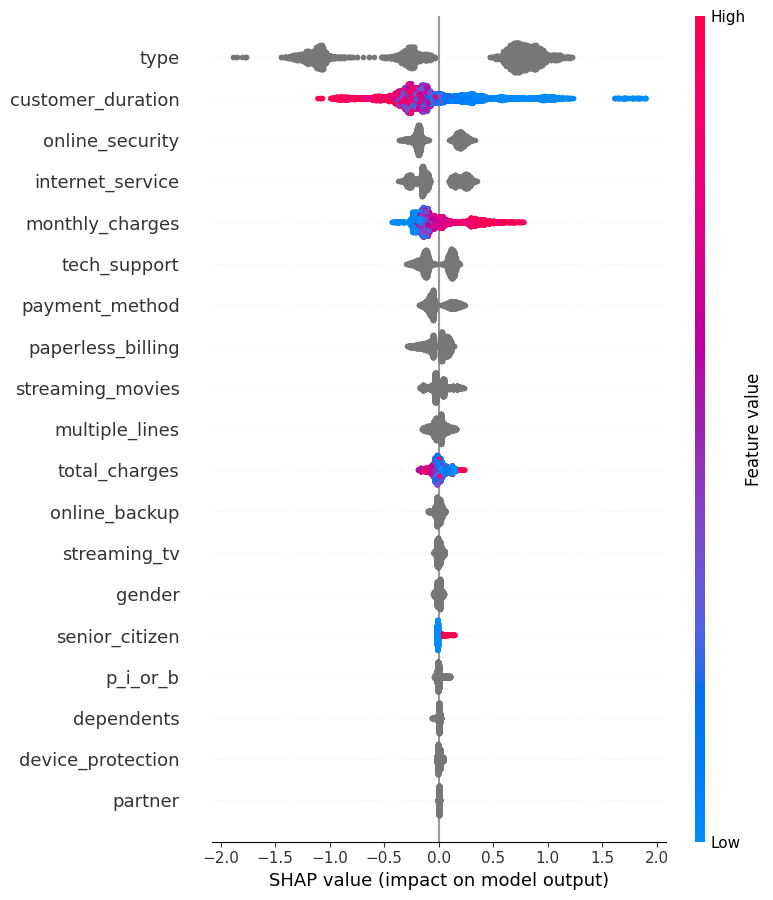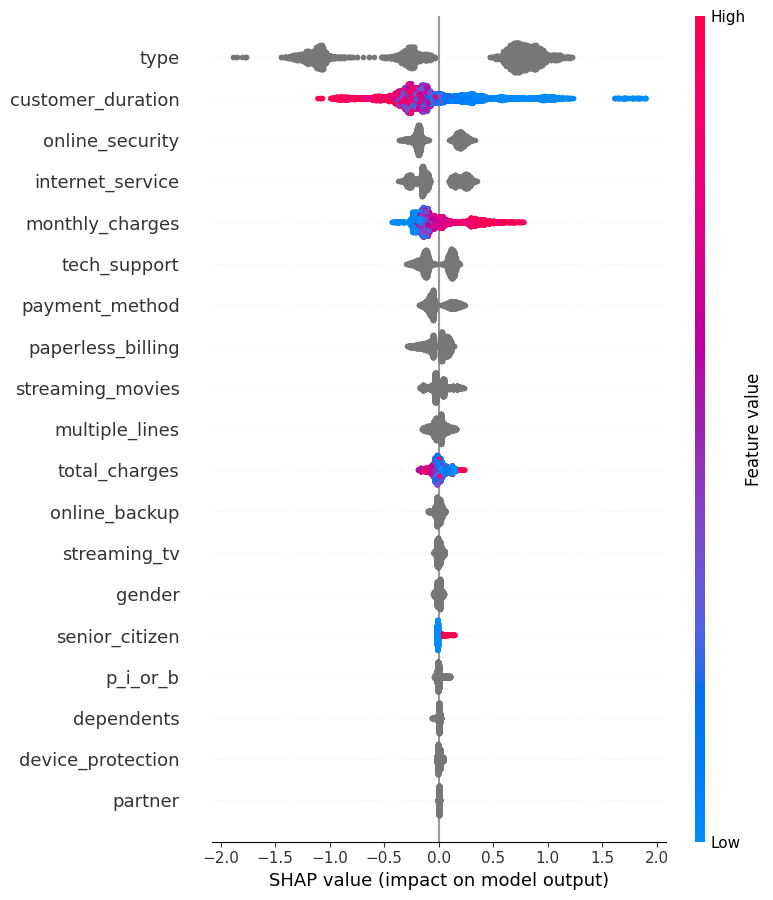

## CatBoostClassifier Hyperparameter Tuning

In [80]:
# Prepare a script for CatBoostClassifier Hyperparameter tuning and SHAP analysis
# Plese note that the SHAP plot may not plot in google colab when run from this .py script. If it doesn't this problem can be solved by 
# entering the code to display the plot manually in a separate google colab notebook cell
# (This code is tailored for google colab, but can be revised to run on desired GPU platofrm)

# Define a function to clean zero-width characters 
def clean(text):
    return text.replace('\u200b', '')

# ===== Colab Setup (Insert this directly into the script) =====
colab_setup = clean("""
# ============================
# COLAB SETUP (Run only if in Colab)
# ============================
import sys
import os
from pathlib import Path

try:
    import google.colab
    from google.colab import drive
    drive.mount('/content/drive')

    # Adjust this path if needed
    project_path = Path('/content/drive/MyDrive/predicting_cust_churn')
    sys.path.append(str(project_path))
    os.chdir(project_path)

except ImportError:
    pass  # Not running in Colab
""")

# Define the import section as a string 
init_str = clean("""

# For type hints
from typing import Optional

# Colab utilities
from google.colab import files

# Core third-party libraries
import numpy as np
import pandas as pd
import shap
import matplotlib.pyplot as plt

# CatBoost
from catboost import CatBoostClassifier, Pool

# Scikit-learn: model selection and evaluation and type hints
from sklearn.base import BaseEstimator
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

# Local Utilities
from src.model_utils import tuning_cv, accuacy_calc, shap_eval
""")

# Write to a script file
with open('src/catboost_gpu_tuning.py', 'w') as f:
    
    # Write the import section
    f.write(init_str)
    f.write('\n\n')

    # Write the main script logic
    main_script = clean("""
if __name__ == '__main__':

    train_df_cat = pd.read_csv('train_data_cat.csv')
    test_df_cat = pd.read_csv('test_data_cat.csv')

    features_train_cat = train_df_cat.drop('target', axis=1)
    target_train_cat = train_df_cat['target']

    features_test_cat = test_df_cat.drop('target', axis=1)
    target_test_cat = test_df_cat['target']

    categorical_cols = ['type',
                    'paperless_billing',
                    'payment_method',
                    'gender',
                    'partner',
                    'dependents',
                    'p_i_or_b',
                    'internet_service',
                    'online_security',
                    'online_backup',
                    'device_protection',
                    'tech_support',
                    'streaming_tv',
                    'streaming_movies',
                    'multiple_lines']

    model_cat = CatBoostClassifier(random_seed=12345, eval_metric='AUC', task_type='GPU')

    

    param_grid = {
    'iterations': [100, 300],               # Keep it light but effective
    'depth': [4, 6],                        # Balanced tree depth options
    'learning_rate': [0.05, 0.1],           # Two sensible learning rates
    'l2_leaf_reg': [3, 7],                  # Light regularization options
    'border_count': [32, 50],               # Numerical feature binning splits
    'random_strength': [1, 2],              # Control randomness in splitting
    'bagging_temperature': [0, 1],          # Simple bagging temps to test
    'scale_pos_weight': [1, 3]}             # Basic class imbalance adjustment

    model_cat = tuning_cv(features_train_cat, 
                                   target_train_cat, 
                                   model_cat, 
                                   param_grid,
                                   cat_features=categorical_cols)

    accuracy_calc(features_train_cat, 
                  target_train_cat,  
                  model_cat)

    

    shap_eval(model_cat, 
              features_train_cat, 
              target_train_cat)
""")

    f.write(main_script)
    f.write('\n')

Best parameters found:  {'bagging_temperature': 0, 'border_count': 32, 'depth': 4, 'iterations': 300, 'l2_leaf_reg': 7, 'learning_rate': 0.05, 'random_strength': 1, 'scale_pos_weight': 1}
Best cross-validation score:  0.8476134197542383

Mean accuracy: 0.8065317713880015

type: 0.5629327128174821  
paperless_billing: 0.21335709694496394  
payment_method: 0.15970629378865978  
monthly_charges: 0.3991910882156918  
total_charges: 0.11489501703571352  
gender: 0.02431651443703057  
senior_citizen: 0.056661025371602204  
partner: 0.007386325511558978  
dependents: 0.05122888143831524  
p_i_or_b: 0.02939404900768406  
internet_service: 0.15438300014539827  
online_security: 0.20511181332759257  
online_backup: 0.04953439453111887  
device_protection: 0.04004968828882068  
tech_support: 0.20268847078769675  
streaming_tv: 0.022748356796284216  
streaming_movies: 0.024877230831195987  
multiple_lines: 0.09616576719156072  
customer_duration: 0.5542773140666561  

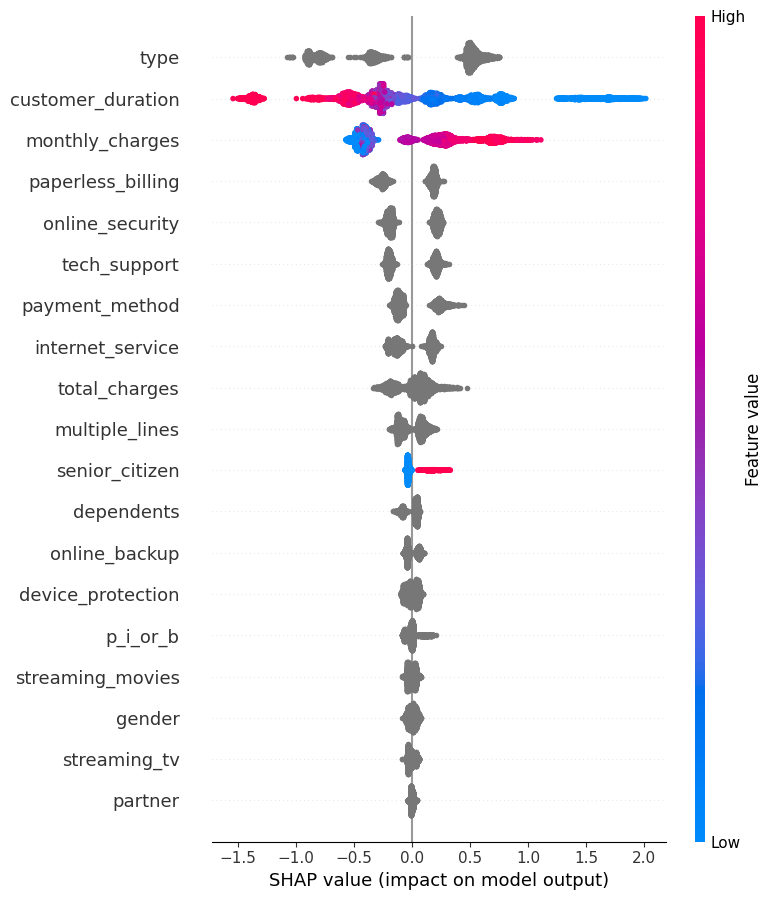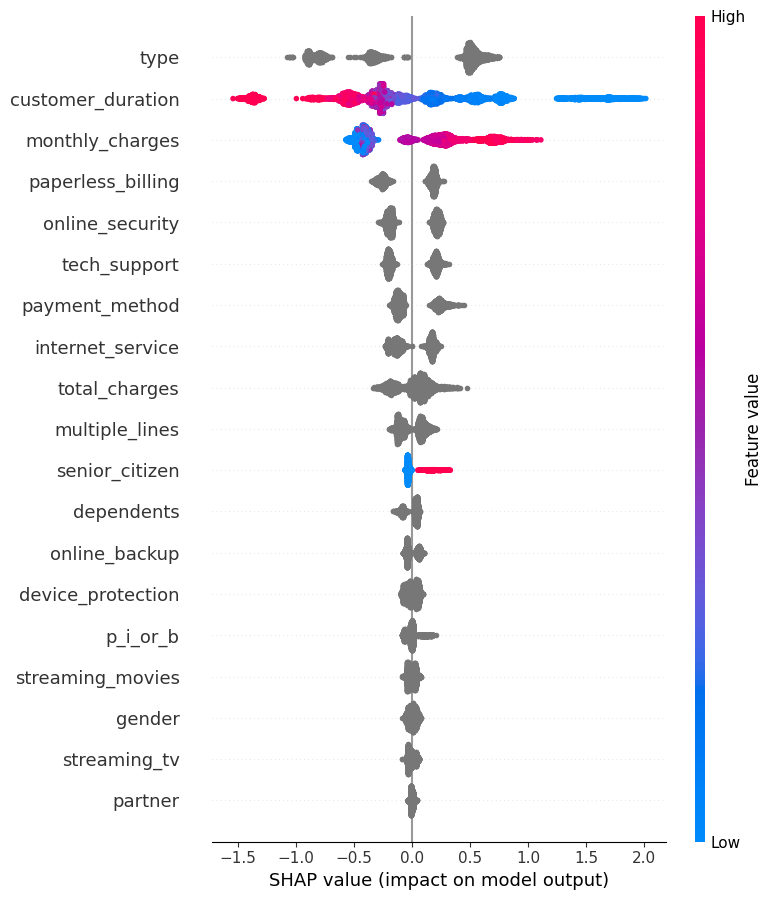

## XGBoostClassifier Hyperparameter Tuning

In [81]:
# Prepare a script for XGBoostClassifier Hyperparameter tuning and SHAP analysis. Plese note that the SHAP plot may not plot in google colab when run from this .py script. If it doesn't this problem can be solved by 
# entering the code to display the plot manually in a separate google colab notebook cell 
# (This code was tailored for google colab, but can be revised to run on desired GPU platofrm)

# Define a function to clean zero-width characters 
def clean(text):
    return text.replace('\u200b', '')

# ===== Colab Setup (Insert this directly into the script) =====
colab_setup = clean("""
# ============================
# COLAB SETUP (Run only if in Colab)
# ============================
import sys
import os
from pathlib import Path

try:
    import google.colab
    from google.colab import drive
    drive.mount('/content/drive')

    # Adjust this path if needed
    project_path = Path('/content/drive/MyDrive/predicting_cust_churn')
    sys.path.append(str(project_path))
    os.chdir(project_path)

except ImportError:
    pass  # Not running in Colab
""")

# Define the import section as a string 
init_str = clean("""

# For type hints
from typing import Optional

# Colab utilities
from google.colab import files

# Core third-party libraries
import numpy as np
import pandas as pd
import shap
import matplotlib.pyplot as plt
import joblib

# XGBoost
import xgboost
from xgboost import XGBClassifier

# Scikit-learn: model selection and evaluation and type hints
from sklearn.base import BaseEstimator
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

# Local Utilities
from src.model_utils import tuning_cv, accuracy_calc, shap_eval
""")


# Write to a script file
with open('src/xgb_gpu_tuning.py', 'w') as f:
    
    # Write the import section
    f.write(init_str)
    f.write('\n\n')

    # Write the main script logic
    main_script = clean("""
if __name__ == '__main__':

    # Make sure we have xgboost version that can handle categorical variables natively
    print(xgboost.__version__)

    train_df_light_xgb = pd.read_csv('train_data_light_xgb.csv')
    test_df_light_xgb = pd.read_csv('test_data_light_xgb.csv')

    categorical_cols = ['type',
                    'total_charges',
                    'paperless_billing',
                    'payment_method',
                    'gender', 
                    'partner',
                    'dependents',
                    'p_i_or_b',
                    'internet_service',
                    'online_security',
                    'online_backup',
                    'device_protection',
                    'tech_support',
                    'streaming_tv',
                    'streaming_movies',
                    'multiple_lines']

    features_train_light_xgb = train_df_light_xgb.drop('target', axis=1)
    target_train_light_xgb = train_df_light_xgb['target']

    features_test_light_xgb = test_df_light_xgb.drop('target', axis=1)
    target_test_light_xgb = test_df_light_xgb['target']

    features_train_light_xgb[categorical_cols] = features_train_light_xgb[categorical_cols].astype('category')
    features_test_light_xgb[categorical_cols] = features_test_light_xgb[categorical_cols].astype('category')

    model_xgb = XGBClassifier(
    tree_method="gpu_hist",
    enable_categorical=True,        # enables native handling of categorical features
    predictor="gpu_predictor",      # optional for faster inference
    use_label_encoder=False,
    eval_metric='auc',
    random_state=12345)

    param_grid = {
    'n_estimators': [100, 300],
    'max_depth': [3, 5],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.7, 1.0],
    'colsample_bytree': [0.7, 1.0],
    'scale_pos_weight': [3, 4]}  # imbalance adjustment


    model_xgb = tuning_cv(features_train_light_xgb, 
                                   target_train_light_xgb, 
                                   model_xgb, 
                                   param_grid)

    accuracy_calc(features_train_light_xgb, 
                  target_train_light_xgb,  
                  model_xgb)

    

    shap_eval(model_xgb, 
              features_train_light_xgb, 
              target_train_light_xgb)

    # Save model to project directory
    joblib.dump(model_xgb, 'model_xgb.pkl')
""")

    f.write(main_script)
    f.write('\n')

Best parameters found:  {'colsample_bytree': 0.7, 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 100, 'scale_pos_weight': 3, 'subsample': 1.0}
Best cross-validation score:  0.8514047733343194

Mean accuracy: 0.756833510827121

type: 0.7410585880279541  
paperless_billing: 0.11170034110546112  
payment_method: 0.16269631683826447  
monthly_charges: 0.22055085003376007  
total_charges: 0.149507537484169  
gender: 0.020929714664816856  
senior_citizen: 0.037514958530664444  
partner: 0.0032620790880173445  
dependents: 0.01970694586634636  
p_i_or_b: 0.02239968627691269  
internet_service: 0.23634448647499084  
online_security: 0.22665317356586456  
online_backup: 0.027191603556275368  
device_protection: 0.012100759893655777  
tech_support: 0.1395595222711563  
streaming_tv: 0.043995488435029984  
streaming_movies: 0.0830724760890007  
multiple_lines: 0.08425364643335342  
customer_duration: 0.48513731360435486  



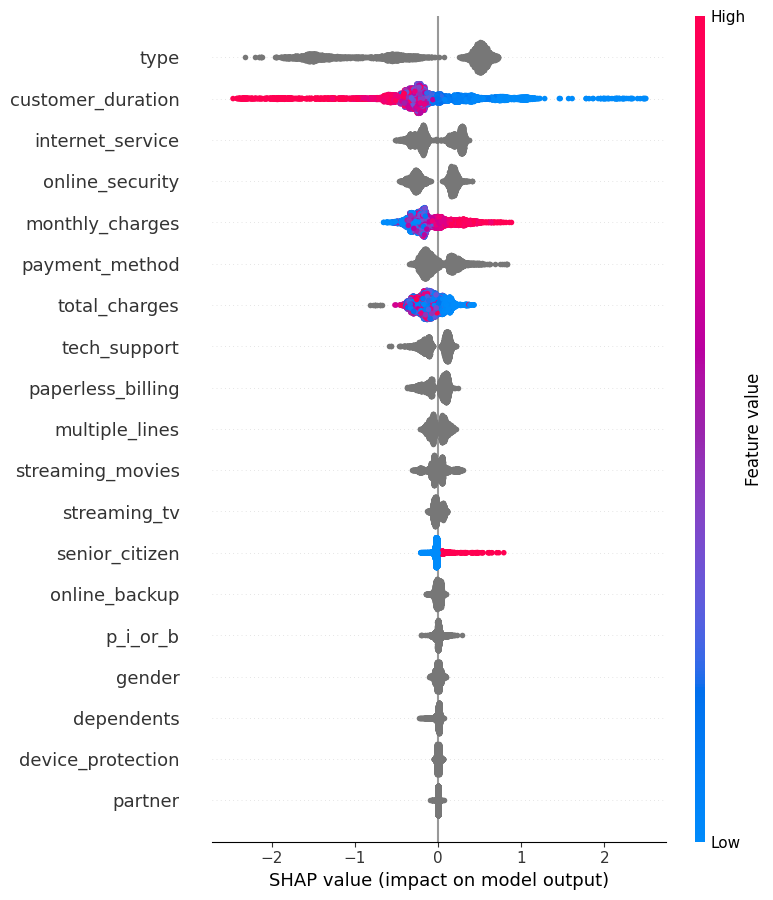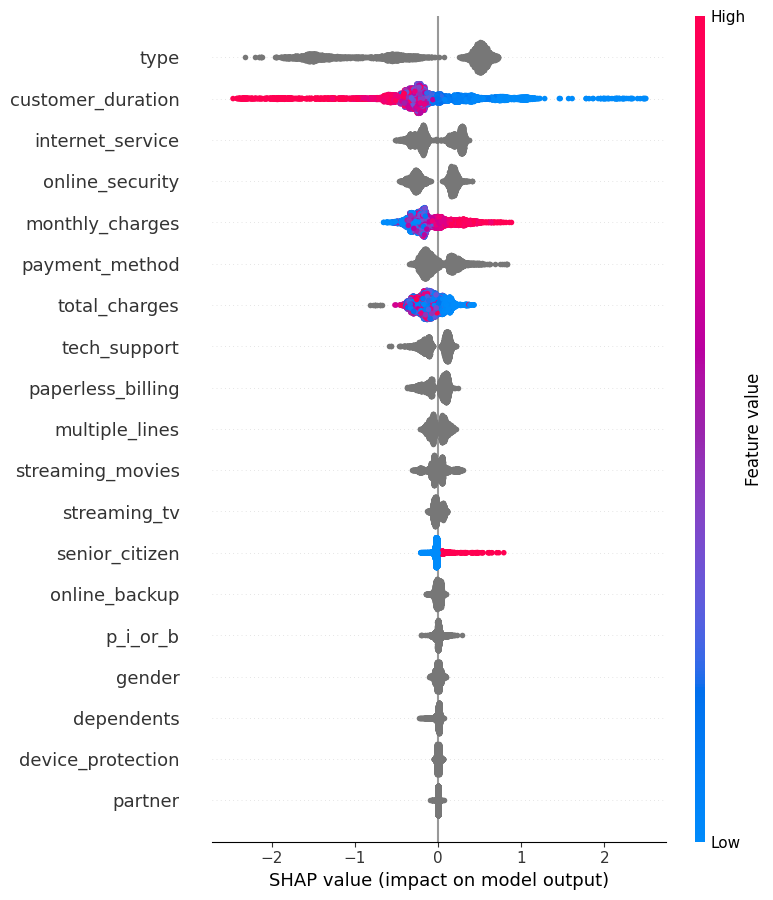

## Threshold Calculation, Final Model Training, Final Model Testing, and Final Model SHAP Analysis

In [82]:
# Prepare a script to find the optimal prediction threshold during the cross validation phase,
# train the best model on full training set, and measure its performance on test set with roc_auc, accuracy_score, and recall_score
# This code will also perform a SHAO analysis on the model's features
# Since the model that performed best during hyperparameter tuning was XGBoost that is the model we are giong to use
# However, this code can be adjusted slightly to accomodate the other two gradient boosting models we considered as well. 
# Plese note that the SHAP plot may not plot in google colab when run from this .py script. If it doesn't this problem can be solved by 
# entering the code to display the plot manually in a separate google colab notebook cell
# (This code is tailored for google colab, but can be revised to run on desired GPU platofrm)

# Define a function to clean zero-width characters 
def clean(text):
    return text.replace('\u200b', '')

# ===== Colab Setup (Insert this directly into the script) =====
colab_setup = clean("""
# ============================
# COLAB SETUP (Run only if in Colab)
# ============================
import sys
import os
from pathlib import Path

try:
    import google.colab
    from google.colab import drive
    drive.mount('/content/drive')

    # Adjust this path if needed
    project_path = Path('/content/drive/MyDrive/predicting_cust_churn')
    sys.path.append(str(project_path))
    os.chdir(project_path)

except ImportError:
    pass  # Not running in Colab
""")

# Define the import section as a string 
init_str = clean("""

# Standard library imports
import os

# For type hints
from typing import Optional

# Colab utilities
from google.colab import files

# Core third-party libraries
import numpy as np
import pandas as pd
import shap
import matplotlib.pyplot as plt
import joblib

# XGBoost
import xgboost
from xgboost import XGBClassifier

# Scikit-learn: model selection and evaluation and type hints
from sklearn.base import BaseEstimator
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict

# Local Utilities
from src.model_utils import threshold_calc, print_metrics, shap_eval
""")

# Write to a script file
with open('src/xgb_testing.py', 'w') as f:
    
    # Write the import section
    f.write(init_str)
    f.write('\n\n')

    # Write the main script logic
    main_script = clean("""
if __name__ == '__main__':

    # Make sure we have xgboost version that can handle categorical variables natively
    print(xgboost.__version__)

    train_df_light_xgb = pd.read_csv('train_data_light_xgb.csv')
    test_df_light_xgb = pd.read_csv('test_data_light_xgb.csv')

    categorical_cols = ['type',
                    'total_charges',
                    'paperless_billing',
                    'payment_method',
                    'gender', 
                    'partner',
                    'dependents',
                    'p_i_or_b',
                    'internet_service',
                    'online_security',
                    'online_backup',
                    'device_protection',
                    'tech_support',
                    'streaming_tv',
                    'streaming_movies',
                    'multiple_lines']
    
    

    features_train_light_xgb = train_df_light_xgb.drop('target', axis=1)
    target_train_light_xgb = train_df_light_xgb['target']

    features_test_light_xgb = test_df_light_xgb.drop('target', axis=1)
    target_test_light_xgb = test_df_light_xgb['target']

    features_train_light_xgb[categorical_cols] = features_train_light_xgb[categorical_cols].astype('category')
    features_test_light_xgb[categorical_cols] = features_test_light_xgb[categorical_cols].astype('category')

    # Load model if the file exists
    model_path = "model_xgb.pkl"
    if os.path.exists(model_path):
        model_xgb = joblib.load(model_path)
        print("Loaded model_xgb from file.")
    else:
        raise FileNotFoundError(f"{model_path} not found. Make sure the model was trained and saved.")


    optimal_threshold = threshold_calc(model_xgb, 
                                    features_train_light_xgb, 
                                    target_train_light_xgb)

    print_metrics(model_xgb, 
                  features_train_light_xgb, 
                  target_train_light_xgb, 
                  features_test_light_xgb, 
                  target_test_light_xgb,
                  optimal_threshold)

    shap_eval(model_xgb, 
              features_test_light_xgb, 
              target_test_light_xgb)

""")

    f.write(main_script)
    f.write('\n')

Optimal threshold: 0.4946

Roc_Auc score for model_xgb: 0.9003826882068842  
Accuracy score: 0.789847355342563  
Recall score: 0.8802675585284281  

type: 0.7410585880279541  
paperless_billing: 0.11170034110546112  
payment_method: 0.16269631683826447  
monthly_charges: 0.22055085003376007  
total_charges: 0.149507537484169  
gender: 0.020929714664816856  
senior_citizen: 0.037514958530664444  
partner: 0.0032620790880173445  
dependents: 0.01970694586634636  
p_i_or_b: 0.02239968627691269  
internet_service: 0.23634448647499084  
online_security: 0.22665317356586456  
online_backup: 0.027191603556275368  
device_protection: 0.012100759893655777  
tech_support: 0.1395595222711563  
streaming_tv: 0.043995488435029984  
streaming_movies: 0.0830724760890007  
multiple_lines: 0.08425364643335342  
customer_duration: 0.48513731360435486  

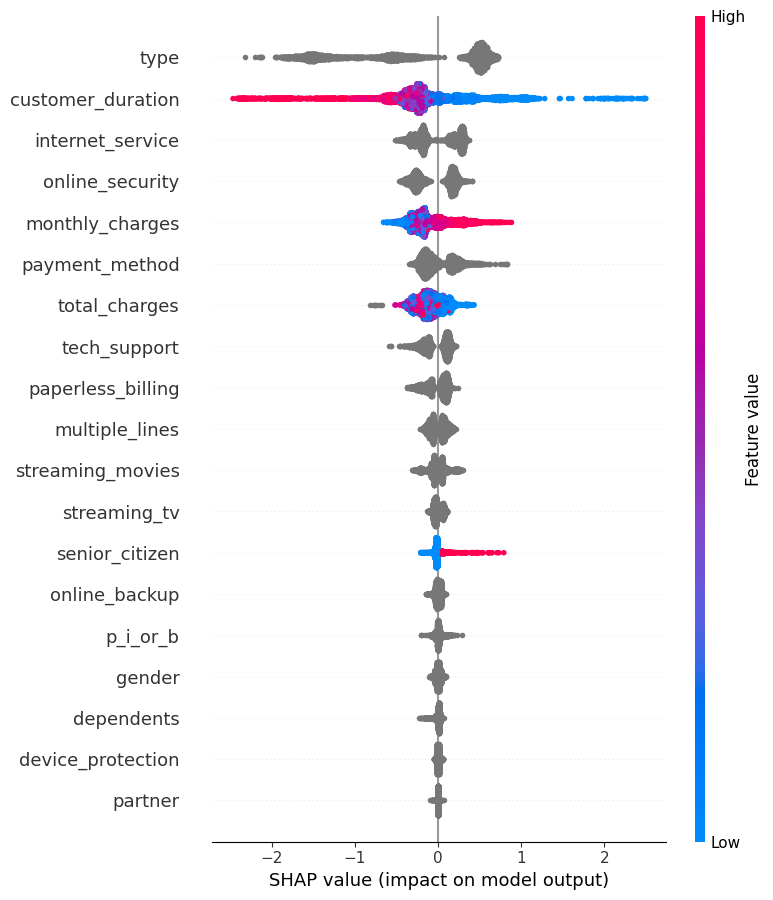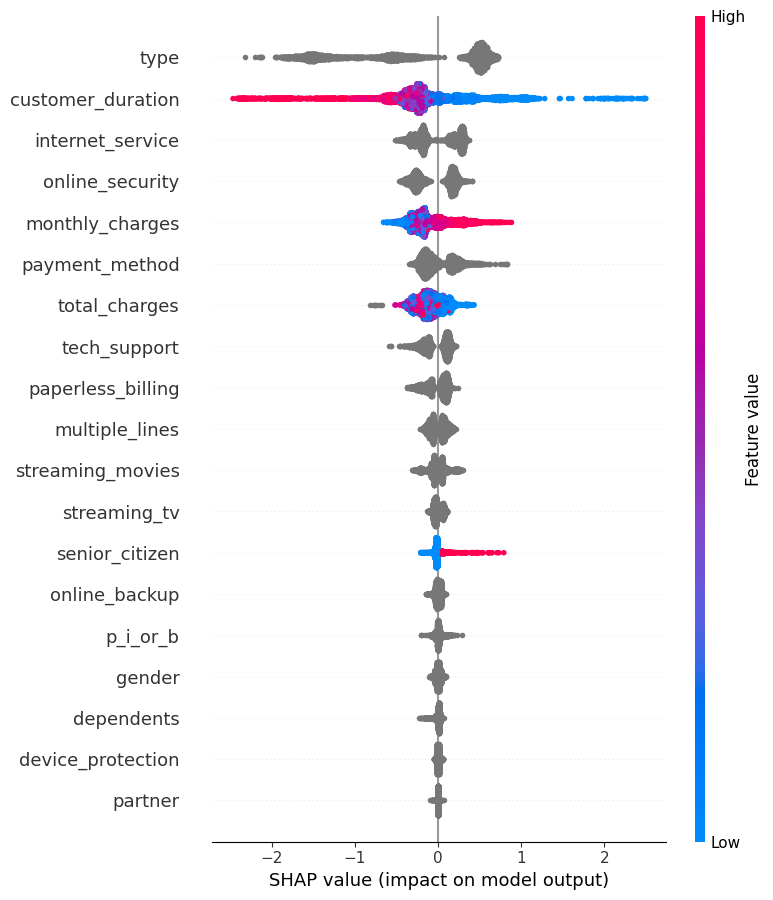

Plese note that you will have to run some version of the following code depending on what GPU platform you choose to run these scripts on. As noted previously, the above scripts are currently tailored to goole colab. 

```
!pip install shap  
!pip install catboost

from google.colab import files  
uploaded = files.upload()```
